In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

import math

In [2]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i, pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [3]:
#LOAD DATA
train = pd.read_table("train.tsv")
test = pd.read_table("test.tsv")
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [4]:
#HANDLE MISSING VALUES
def handle_missing(dataset):
    dataset.category_name.fillna(value="_LEFTBLANK_", inplace=True)
    dataset.brand_name.fillna(value="_LEFTBLANK_", inplace=True)
    dataset.item_description.fillna(value="_LEFTBLANK_", inplace=True)
    return dataset

train = handle_missing(train)
test = handle_missing(test)

In [5]:
#PROCESS CATEGORICAL DATA
labeler = LabelEncoder()

# hstack is essentially appending the two datasets
labeler.fit(np.hstack([train.category_name, test.category_name]))

train.category_name = labeler.transform(train.category_name)
test.category_name = labeler.transform(test.category_name)

labeler.fit(np.hstack([train.brand_name, test.brand_name]))

train.brand_name = labeler.transform(train.brand_name)
test.brand_name = labeler.transform(test.brand_name)

train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5204,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


In [6]:
# TODO: Expand the category names into separate columns and then try label encoding that instead

In [7]:
#PROCESS RAW TEXT
from keras.preprocessing.text import Tokenizer

print("Text to seq process...")
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_text)

print("Transforming text to seq...")
train["seq_item_description"] = tokenizer.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tokenizer.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tokenizer.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tokenizer.texts_to_sequences(test.name.str.lower())

train.head(3)

Using TensorFlow backend.


Text to seq process...
Fitting tokenizer...
Transforming text to seq...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5204,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


In [8]:
#SEQUENCES VARIABLES ANALYSIS
itemnames = np.hstack([train.seq_name, test.seq_name])
itemnames_len = pd.Series(itemnames).apply(len)
print("max name seq:", itemnames_len.max())

itemdescs = np.hstack([train.seq_item_description, test.seq_item_description])
itemdescs_len = pd.Series(itemdescs).apply(len)
print("max item desc seq", itemdescs_len.max())

max name seq: 17
max item desc seq 269


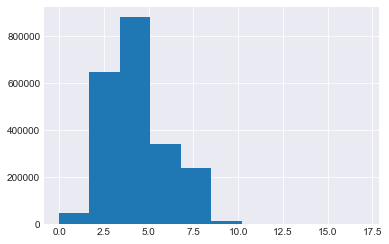

In [9]:
itemnames_len.hist()

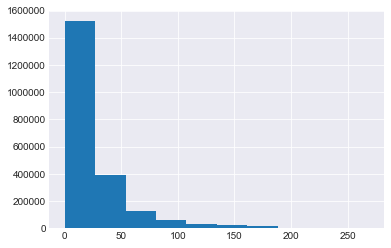

In [10]:
itemdescs_len.hist()

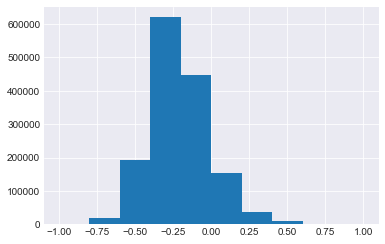

In [12]:
# Scale target variable
train["target"] = np.log1p(train.price)
target_scaler = MinMaxScaler(feature_range=(-1, 1))

train["target"] = target_scaler.fit_transform(train["target"].values.reshape(-1,1))
train.target.hist()

In [13]:
# CREATE VALIDATION DATA
dtrain, dval = train_test_split(train, random_state=100, test_size=0.01)

print(dtrain.shape)
print(dval.shape)

(1467709, 11)
(14826, 11)


In [11]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths

MAX_NAME_SEQ = 12
MAX_ITEM_DESC_SEQ = 100

MAX_TOKEN = len(tokenizer.word_index) + 1
# 259089

MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()]) + 1
# 1311

MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()]) + 1
# 5290

MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()]) + 1
# 6

dtrain and dval are training and validation dataframes. They both have x and y values, but we separate the x's in the next step.

In [14]:
# KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'brand_name': np.array(dataset.brand_name),
        'category_name': np.array(dataset.category_name),
        'item_condition': np.array(dataset.item_condition_id),
        'shipping': np.array(dataset.shipping)
    }
    return X

# X
X_train = get_keras_data(dtrain)
X_val = get_keras_data(dval)

X_test = get_keras_data(test)

# Y
y_train = dtrain['target']
y_val = dval['target']
y_true = dval['price'] # So we can judge our validation score meaningfully

# RNN

In [15]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model_rnn():
    #params
    dropout_rate = 0.1
    
    #Inputs
    name           = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc      = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name     = Input(shape=[1], name="brand_name")
    category_name  = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    shipping       = Input(shape=[1], name="shipping")
    
    #Embedding layers
    emb_name           = Embedding(MAX_TOKEN, 50)(name)
    emb_item_desc      = Embedding(MAX_TOKEN, 50)(item_desc)
    emb_brand_name     = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name  = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16)(emb_item_desc)
    rnn_layer2 = GRU(8)(emb_name)
    
    #main layer
    main_layer = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_category_name),
        Flatten() (emb_item_condition),
        rnn_layer1,
        rnn_layer2,
        shipping
    ])
    main_layer = Dropout(dropout_rate) (Dense(128) (main_layer))
    main_layer = Dropout(dropout_rate) (Dense(64) (main_layer))
    
    #output
    output = Dense(1, activation="linear") (main_layer)
    
    #model
    model = Model([name, item_desc, brand_name,
                   category_name, item_condition, shipping], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model_rnn()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
name (Inpu

In [16]:
#FITTING THE MODEL
BATCH_SIZE = 1024
epochs = 1

model = get_model_rnn()
model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_val, y_val), verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/1
1467709/1467709 [==============================] - 1045s 712us/step - loss: 0.0180 - mean_absolute_error: 0.1009 - rmsle_cust: 0.0131 - val_loss: 0.0152 - val_mean_absolute_error: 0.0923 - val_rmsle_cust: 0.0122


In [17]:
# EVALUATE THE MODEL ON VALIDATION DATA: What is it doing?
y_pred = model.predict(X_val)
y_pred = target_scaler.inverse_transform(y_pred)
y_pred = np.expm1(y_pred)
y_pred = y_pred.flatten()

# mean_squared_log_error
v_rmsle = rmsle(y_true.values, y_pred)
print("RMSLE on validation data:", v_rmsle)

RMSLE on validation data: 0.4690057573250844


In [18]:
from sklearn.metrics import mean_absolute_error

v_mae = mean_absolute_error(y_true.values, y_pred)
print("MAE on validation data:", v_mae)

MAE on validation data: 10.219458882390255


In [19]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true.values, y_pred)
print("R2 on validation data:", r2)

R2 on validation data: 0.4709599069262139


# CNN

In [20]:
#KERAS MODEL DEFINITION
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model_cnn():
    #params
    dropout_rate = 0.1
    
    #Inputs
    name           = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc      = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name     = Input(shape=[1], name="brand_name")
    category_name  = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    shipping       = Input(shape=[1], name="shipping")
    
    #Embeddings layers
    emb_name           = Embedding(MAX_TOKEN, 50)(name)
    emb_item_desc      = Embedding(MAX_TOKEN, 50)(item_desc)
    emb_brand_name     = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name  = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #cnn layer
    cnn_layer1 = Conv1D(filters=512, kernel_size=3,
                        padding='valid', activation='relu',
                       strides=1) (emb_item_desc)
    cnn_layer1 = MaxPool1D() (cnn_layer1)
    cnn_layer1 = Flatten() (cnn_layer1)
    
    cnn_layer2 = Conv1D(filters=512, kernel_size=3,
                        padding='valid', activation='relu',
                       strides=1) (emb_name)
    cnn_layer2 = MaxPool1D() (cnn_layer2)
    cnn_layer2 = Flatten() (cnn_layer2)
    
    #main layer
    main_layer = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_category_name),
        Flatten() (emb_item_condition),
        cnn_layer1,
        cnn_layer2,
        shipping
    ])
    main_layer = Dropout(dropout_rate) (Dense(128) (main_layer))
    main_layer = Dropout(dropout_rate) (Dense(64) (main_layer))
    
    #output
    output = Dense(1, activation="linear") (main_layer)
    
    #model
    model = Model([name, item_desc, brand_name,
                   category_name, item_condition, shipping], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model_cnn()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 12)           0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 100, 50)      12954450    item_desc[0][0]                  
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 12, 50)       12954450    name[0][0]                       
__________________________________________________________________________________________________
brand_name

In [21]:
#FITTING THE MODEL
BATCH_SIZE = 1024
epochs = 1

model = get_model_cnn()
model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_val, y_val), verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/1
1467709/1467709 [==============================] - 5385s 4ms/step - loss: 0.0252 - mean_absolute_error: 0.1059 - rmsle_cust: 0.0148 - val_loss: 0.0147 - val_mean_absolute_error: 0.0905 - val_rmsle_cust: 0.0120


In [22]:
# EVALUATE THE MODEL ON VALIDATION DATA: What is it doing?
y_pred = model.predict(X_val)
y_pred = target_scaler.inverse_transform(y_pred)
y_pred = np.expm1(y_pred)
y_pred = y_pred.flatten()

# mean_squared_log_error
v_rmsle = rmsle(y_true.values, y_pred)
print("RMSLE on validation data:", v_rmsle)

RMSLE on validation data: 0.4608125233089771


In [23]:
from sklearn.metrics import mean_absolute_error

v_mae = mean_absolute_error(y_true.values, y_pred)
print("MAE on validation data:", v_mae)

MAE on validation data: 10.049219869399833


In [24]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true.values, y_pred)
print("R2 on validation data:", r2)

R2 on validation data: 0.5075883561378365


In [ ]:
# #CREATE PREDICTIONS
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.expm1(preds)

submission = test[["test_id"]]
submission["price"] = preds

submission.to_csv("submission.csv", index=False)
pd.Series(np.log1p(submission.price)).hist(bins=20)